<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error


In [42]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [43]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [57]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)

In [58]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','타석','득점','안타','1타','2타','3타','홈런','루타','타점','볼넷','삼진'\
        ,'타율','출루','isoD','장타','isoP','OPS','wOBA','wRC+','WAR+']

In [59]:
# 누적 및 lag stat features 이름
stats_age = [i + '_AGE' for i in stats]
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [60]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum+ stats_lag1  + stats_lag2 + stats_lag3   + ['나이'] +['연차']
y_cols = ['OPS_NEXT']

#z_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_lag3 +  stats_age + ['나이']
#X_cols = stats + stats_cum+ stats_lag1  + stats_lag2 + stats_lag3 + stats_position  + stats_age + ['나이']
#stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
#        ,'병살','희타','희비','타율','출루','isoD','장타','isoP','OPS','wOBA','wRC+','WAR+','연차']

#예측에 사용되는 수치형 데이터 표준화
z_cols =  stats + stats_cum + stats_lag1 + stats_lag2 + stats_lag3 + ['나이'] + ['연차']
stand = pd.DataFrame(data=result,columns=z_cols)
scaler = StandardScaler()
scaler.fit(stand)
data_scaled = scaler.transform(stand)
result_scaled = pd.DataFrame(data_scaled,columns=z_cols)
result[z_cols] = result_scaled[z_cols]



/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [61]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
df= df.reset_index(drop=True)
df

,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,연차,1B,2B,3B,C,CF,DH,LF,RF,SS
0,0,이종범,1970-08-15,해,1994,SS,-0.932448,1.201137,1.778458,1.853538,...,-1.0,0,0,0,0,0,0,0,0,1
1,1,테임즈,1986-11-10,N,2015,1B,0.210968,1.711759,1.978357,1.670576,...,-1.0,1,0,0,0,0,0,0,0,0
2,2,심정수,1975-05-05,현,2003,RF,-0.017715,1.456448,2.013633,1.589260,...,-1.0,0,0,0,0,0,0,0,1,0
3,0,이종범,1970-08-15,해,1996,SS,-0.475082,0.889089,1.566800,1.514720,...,-1.0,0,0,0,0,0,0,0,0,1
4,3,이승엽,1976-08-18,삼,2002,1B,-0.475082,1.456448,2.107703,1.934854,...,-1.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,272,이성열,1984-07-13,한,2020,DH,1.811750,-0.075420,-0.061790,0.010368,...,-1.0,0,0,0,0,0,1,0,0,0
4503,2195,김규성,1997-03-08,K,2020,2B,-1.161131,0.605410,-0.449830,-0.463977,...,-1.0,0,1,0,0,0,0,0,0,0
4504,793,김태진,1995-10-07,NK,2020,3B,-0.703765,0.009684,0.126350,0.254317,...,-1.0,0,0,1,0,0,0,0,0,0
4505,2197,임종찬,2001-09-28,한,2021,RF,-1.847180,-1.125033,-0.661488,-0.633386,...,-1.0,0,0,0,0,0,0,0,1,0


In [62]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(objective ='reg:squarederror',n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(random_state=23),
              'rf':RandomForestRegressor(max_depth = 10, min_samples_leaf = 12, min_samples_split= 8, n_estimators = 100),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'gbm' : GradientBoostingRegressor(random_state=23)
              }

In [63]:
from sklearn.model_selection import GridSearchCV
model = model_dict['xgb']
model2 = model_dict['rf']
model3 = model_dict['gbm']
model4 = model_dict['ridge']

test_error = []
r2 = []

#학습용 데이터 ~2016 테스트데이터 2016~2021
train = df[df['시즌'] < 2018].reset_index(drop=True)
test = df[(2017 < df['시즌']) & (df['시즌'] < 2022) ].reset_index(drop=True)
y_train = train[y_cols]
y_test = test[y_cols]


params = { 'n_estimators' : [10, 100],  'max_depth' : [6, 8, 10, 12], 'min_samples_leaf' : [8, 12, 18],  'min_samples_split' : [8, 16, 20] }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestRegressor(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(train[X_cols], y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

KeyboardInterrupt: ignored

In [64]:
def get_stacking_base_datasets(model, train,test, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((train.shape[0] ,1 ))
    test_pred = np.zeros((test.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(train)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        tra, val = train.iloc[train_index], train.iloc[valid_index]
        X_tr = tra[X_cols] 
        y_tr = tra[y_cols] 
        X_vl = val[X_cols]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_vl).reshape(-1,1)
        #원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(test[X_cols])   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [65]:
model = model_dict['xgb']
model2 = model_dict['rf']
model3 = model_dict['gbm']
model4 = model_dict['ridge']

test_error = []
r2 = []

#학습용 데이터 ~2016 테스트데이터 2016~2021
train = df[df['시즌'] < 2016].reset_index(drop=True)
test = df[(2015 < df['시즌']) & (df['시즌'] < 2022) ].reset_index(drop=True)
y_train = train[y_cols]
y_test = test[y_cols]

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 

# CV스태킹 알고리즘 각 모델에 적용
xgb_train, xgb_test = get_stacking_base_datasets(model,train,test, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(model2, train,test, 5)
gbm_train, gbm_test = get_stacking_base_datasets(model3,train,test,  5)    

# CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 result_a result_b 만들기 
Stack_final_X_train = np.concatenate((xgb_train, lgbm_train, gbm_train), axis=1)
Stack_final_X_test = np.concatenate((xgb_test, lgbm_test, gbm_test), axis=1)

# 메타 모델 학습
model4.fit(Stack_final_X_train,y_train )
stack_final = model4.predict(Stack_final_X_test)


XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
RandomForestRegressor  model 시작 
	 폴드 세트:  0  시작 


<ipython-input-64-f42c0ceb3cd5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr , y_tr)


	 폴드 세트:  1  시작 


<ipython-input-64-f42c0ceb3cd5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr , y_tr)


	 폴드 세트:  2  시작 


<ipython-input-64-f42c0ceb3cd5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr , y_tr)


	 폴드 세트:  3  시작 


<ipython-input-64-f42c0ceb3cd5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr , y_tr)


	 폴드 세트:  4  시작 


<ipython-input-64-f42c0ceb3cd5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr , y_tr)


GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  1  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  2  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  3  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  4  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
#검증 지표
mse=mean_squared_error(y_test,  stack_final ,squared=False)
rmse =  np.sqrt(mse)
r2 =r2_score(y_test, stack_final)
print("test error : ", mse)
print("RMSE : ", rmse)
print("r2 : ", r2)
print("완료")

test error :  0.11158013681680552
RMSE :  0.33403613100502394
r2 :  0.3716795079540184
완료


,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,타석_AGE,1B,2B,3B,C,CF,DH,LF,RF,SS
0,15,최형우,1983-12-16,삼,2016,LF,1.125700,1.598287,2.113583,1.989065,...,-1.0,0,0,0,0,0,0,1,0,0
1,18,김재환,1988-09-22,두,2017,LF,0.210968,1.768495,2.219412,2.158474,...,-1.0,0,0,0,0,0,0,1,0,0
2,28,박건우,1990-09-08,두,2017,CF,-0.246399,1.399712,1.672629,1.745116,...,-1.0,0,0,0,0,1,0,0,0,0
3,18,김재환,1988-09-22,두,2018,LF,0.439651,1.626655,2.019513,2.043276,...,-1.0,0,0,0,0,0,0,1,0,0
4,15,최형우,1983-12-16,K,2017,LF,1.354383,1.711759,2.178256,1.955183,...,-1.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,272,이성열,1984-07-13,한,2020,DH,1.811750,-0.075420,-0.061790,0.010368,...,-1.0,0,0,0,0,0,1,0,0,0
844,2195,김규성,1997-03-08,K,2020,2B,-1.161131,0.605410,-0.449830,-0.463977,...,-1.0,0,1,0,0,0,0,0,0,0
845,793,김태진,1995-10-07,NK,2020,3B,-0.703765,0.009684,0.126350,0.254317,...,-1.0,0,0,1,0,0,0,0,0,0
846,2197,임종찬,2001-09-28,한,2021,RF,-1.847180,-1.125033,-0.661488,-0.633386,...,-1.0,0,0,0,0,0,0,0,1,0


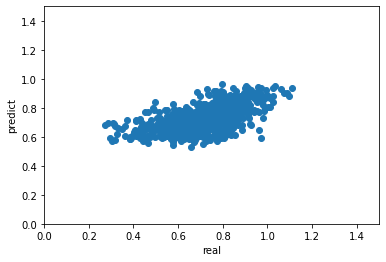

In [54]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, stack_final)
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)
test

In [55]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
sample = test
sample['y_hat'] = stack_final

sample = sample[sample['시즌']==2021]

new = ['이름','생일','y_hat']
new2 = ['이름','생일','팀','시즌','포지션','OPS']
sample = sample[new]

predict = result[result['시즌']==2022] # 2018년도 데이터 프레임
predict=predict[new2]

final = pd.merge(predict, sample, on=('이름','생일'), how='inner')
error = final['OPS'] - final['y_hat']
print("오차 ",np.mean(error))

final


오차  -0.03869703789550918


,이름,생일,팀,시즌,포지션,OPS,y_hat
0,이정후,1998-08-20,키,2022,CF,0.996,0.878666
1,피렐라,1989-11-21,삼,2022,LF,0.976,0.833131
2,나성범,1989-10-03,K,2022,RF,0.910,0.892095
3,오지환,1990-03-12,L,2022,SS,0.827,0.759948
4,최정,1987-02-28,S,2022,3B,0.891,0.888544
...,...,...,...,...,...,...,...
132,김성현,1987-03-09,S,2022,2B,0.570,0.667617
133,이도윤,1996-10-07,한,2022,SS,0.461,0.585946
134,박대온,1995-08-28,N,2022,C,0.429,0.592927
135,박경수,1984-03-31,K,2022,2B,0.427,0.726312


In [56]:
# 기존 모델
# 2009 ~ 2016년 기간의 데이터로 검증 
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(1984, 2022):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
  
    model.fit( X_train, y_train )

    y_predict = model.predict(X_test)
   

    test_error.append(mean_squared_error(y_test,  y_predict,squared=False) )
    r2.append(r2_score(y_test, y_predict))

    clear_output(wait=True)
    print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.sqrt(np.mean(test_error)))
print("r2 : ", np.mean(r2))
print("완료")


2021 : 완료
test error :  0.11665938528213408
RMSE :  0.3415543665101269
r2 :  0.27109853193975886
완료


(0.0, 1.5)

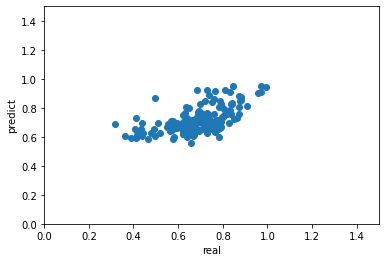

In [ ]:
# 예측값과 실제값의 시각화
plt.scatter(y_test,y_predict )
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [ ]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)

predict = result[result['시즌']==2021] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
X = predict[X_cols]
X = X.fillna(-1) # NA값 -1로 impute
predict['y_hat'] = model.predict(X)
new = ['이름','생일','팀','시즌','포지션','OPS','y_hat']
predict = predict[new]


error = predict['OPS'] - predict['y_hat']
print("오차 ",np.mean(error))



predict

오차  -0.095992764305061


,이름,생일,팀,시즌,포지션,OPS,y_hat
5421,홍창기,1993-11-21,L,2021,CF,0.865,0.744283
5423,이정후,1998-08-20,키,2021,CF,0.959,0.705364
5426,강백호,1999-07-29,K,2021,1B,0.971,0.811897
5429,최정,1987-02-28,S,2021,3B,0.972,0.701018
5434,양의지,1987-06-05,N,2021,DH,0.995,0.742776
...,...,...,...,...,...,...,...
6175,박정현,2001-07-27,한,2021,SS,0.490,0.767322
6198,이원석,1999-03-31,한,2021,CF,0.466,0.768709
6199,유장혁,2000-05-30,한,2021,CF,0.443,0.778634
6201,예진원,1999-03-16,키,2021,CF,0.502,0.774802
